In [1]:
import warnings
warnings.filterwarnings('ignore', message='numpy.dtype size changed')
warnings.filterwarnings('ignore', message='numpy.ufunc size changed')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [170]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from typing import List, Optional, Union

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Import required libraries
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTENC

from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier

from sklearn.semi_supervised import LabelSpreading

# Defining Reusable Functions

In [3]:
def correlation_heatmap(df: pd.DataFrame, x=8, y=6, dpi=100) :
    # First calculate the correlation matrix using pandas
    correlation_matrix = df.corr()
    
    # Create the heatmap using seaborn
    plt.figure(figsize=(x, y), dpi=dpi)
    sns.heatmap(correlation_matrix, 
                annot=True,  # This shows the numbers in each cell
                fmt='.2f',   # Format to 2 decimal places
                cmap='RdBu_r',  # This gives you the red-white-blue colormap similar to the image
                center=0,     # Centers the colormap at 0
                square=True,  # Makes the cells square
                vmin=-1,     # Sets the minimum value for the colormap
                vmax=1)      # Sets the maximum value for the colormap
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Optional: adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [4]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [5]:
def StandardScale(df, columns_to_ignore):
    df_to_scale = df.drop(columns_to_ignore, axis=1)
    
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns, index=df.index)
    
    for col in columns_to_ignore:
        scaled_df[col] = df[col]
    
    return scaled_df

In [6]:
def MinMaxScale(df, columns_to_ignore):
    df_to_scale = df.drop(columns_to_ignore, axis=1)
    
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df_to_scale), columns=df_to_scale.columns, index=df.index)
    
    for col in columns_to_ignore:
        scaled_df[col] = df[col]
    
    return scaled_df

In [7]:
def remove_outliers(df, columns, n_std=3):
   df_clean = df.copy()
   initial_rows = len(df_clean)
   
   for col in columns:
       z_scores = (df_clean[col] - df_clean[col].mean()) / df_clean[col].std()
       df_clean = df_clean[abs(z_scores) <= n_std]
   
   rows_removed = initial_rows - len(df_clean)
   return df_clean, rows_removed

def remove_outliers_iqr(df, columns, k=1.5):
   df_clean = df.copy()
   initial_rows = len(df_clean)
   
   for col in columns:
       Q1 = df_clean[col].quantile(0.10)
       Q3 = df_clean[col].quantile(0.90)
       IQR = Q3 - Q1
       
       df_clean = df_clean[~((df_clean[col] < (Q1 - k * IQR)) | 
                            (df_clean[col] > (Q3 + k * IQR)))]
   
   rows_removed = initial_rows - len(df_clean)
   return df_clean, rows_removed

# Collecting Data

In [8]:
df_train = pd.read_csv(r"train.csv")
# df_test = pd.read_csv(r"test.csv")

In [9]:
df_train.shape

(3960, 82)

In [10]:
# df_test.shape

In [11]:
df_train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# df_test.head()

In [13]:
# print("Columns in Train Set: ", df_train.columns)
# print("Columns in Test Set: ", df_test.columns)

Initial Observations:
1. Test data has fewer columns than Training data.
2. PCIAT features should not be used for modeling since SII is derived from PCIAT, which means including them will lead to data leakage.

# Data Preprocessing

## Initial Analysis

In [14]:
# columns_to_keep = [col for col in df_train.columns if col in df_test.columns or col == 'sii']

# df_train = df_train[columns_to_keep]

# print("Updated Columns in Train Set: ", df_train.columns.tolist())
# print("\nColumns in Test Set: ", df_test.columns.tolist())

In [15]:
for col, dtype in df_train.dtypes.items():
    print(f"Column '{col}' has data type: {dtype}")

Column 'id' has data type: object
Column 'Basic_Demos-Enroll_Season' has data type: object
Column 'Basic_Demos-Age' has data type: int64
Column 'Basic_Demos-Sex' has data type: int64
Column 'CGAS-Season' has data type: object
Column 'CGAS-CGAS_Score' has data type: float64
Column 'Physical-Season' has data type: object
Column 'Physical-BMI' has data type: float64
Column 'Physical-Height' has data type: float64
Column 'Physical-Weight' has data type: float64
Column 'Physical-Waist_Circumference' has data type: float64
Column 'Physical-Diastolic_BP' has data type: float64
Column 'Physical-HeartRate' has data type: float64
Column 'Physical-Systolic_BP' has data type: float64
Column 'Fitness_Endurance-Season' has data type: object
Column 'Fitness_Endurance-Max_Stage' has data type: float64
Column 'Fitness_Endurance-Time_Mins' has data type: float64
Column 'Fitness_Endurance-Time_Sec' has data type: float64
Column 'FGC-Season' has data type: object
Column 'FGC-FGC_CU' has data type: float64

## Substituting Numerical Categorical Features with String from DataDictionary.csv

We do this because categorical features should be trained as **object** datatypes. But Categorical types in Dataframe are of types **float64** or **int64**

In [16]:
df_train['Basic_Demos-Sex'] = df_train['Basic_Demos-Sex'].replace({0: 'Male', 1: 'Female'})
df_train['FGC-FGC_CU_Zone'] = df_train['FGC-FGC_CU_Zone'].replace({0: 'Needs Improvement', 1: 'Healthy Fitness Zone'})
df_train['FGC-FGC_GSND_Zone'] = df_train['FGC-FGC_GSND_Zone'].replace({1: 'Weak', 2: 'Normal', 3: 'Strong'})
df_train['FGC-FGC_GSD_Zone'] = df_train['FGC-FGC_GSD_Zone'].replace({1: 'Weak', 2: 'Normal', 3: 'Strong'})
df_train['FGC-FGC_PU_Zone'] = df_train['FGC-FGC_PU_Zone'].replace({0: 'Needs Improvement', 1: 'Healthy Fitness Zone'})
df_train['FGC-FGC_SRL_Zone'] = df_train['FGC-FGC_SRL_Zone'].replace({0: 'Needs Improvement', 1: 'Healthy Fitness Zone'})
df_train['FGC-FGC_SRR_Zone'] = df_train['FGC-FGC_SRR_Zone'].replace({0: 'Needs Improvement', 1: 'Healthy Fitness Zone'})
df_train['FGC-FGC_TL_Zone'] = df_train['FGC-FGC_TL_Zone'].replace({0: 'Needs Improvement', 1: 'Healthy Fitness Zone'})
df_train['BIA-BIA_Activity_Level_num'] = df_train['BIA-BIA_Activity_Level_num'].replace({1: 'Very Light', 2: 'Light', 3: 'Moderate', 4: 'Heavy', 5: 'Exceptional'})
df_train['BIA-BIA_Frame_num'] = df_train['BIA-BIA_Frame_num'].replace({1: 'Small', 2: 'Medium', 3: 'Large'})
df_train['PCIAT-PCIAT_01'] = df_train['PCIAT-PCIAT_01'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_02'] = df_train['PCIAT-PCIAT_02'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_03'] = df_train['PCIAT-PCIAT_03'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_04'] = df_train['PCIAT-PCIAT_04'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_05'] = df_train['PCIAT-PCIAT_05'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_06'] = df_train['PCIAT-PCIAT_06'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_07'] = df_train['PCIAT-PCIAT_07'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_08'] = df_train['PCIAT-PCIAT_08'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_09'] = df_train['PCIAT-PCIAT_09'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_10'] = df_train['PCIAT-PCIAT_10'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_11'] = df_train['PCIAT-PCIAT_11'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_12'] = df_train['PCIAT-PCIAT_12'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_13'] = df_train['PCIAT-PCIAT_13'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_14'] = df_train['PCIAT-PCIAT_14'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_15'] = df_train['PCIAT-PCIAT_15'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_16'] = df_train['PCIAT-PCIAT_16'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_17'] = df_train['PCIAT-PCIAT_17'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_18'] = df_train['PCIAT-PCIAT_18'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_19'] = df_train['PCIAT-PCIAT_19'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PCIAT-PCIAT_20'] = df_train['PCIAT-PCIAT_20'].replace({0: 'Does Not Apply', 1: 'Rarely', 2: 'Occasionally', 3: 'Frequently', 4: 'Often', 5: 'Always'})
df_train['PreInt_EduHx-computerinternet_hoursday'] = df_train['PreInt_EduHx-computerinternet_hoursday'].replace({0: 'Less than 1h/day', 1: 'Around 1h/day', 2: 'Around 2hs/day', 3: 'More than 3hs/day'})
df_train['sii'] = df_train['sii'].replace({0: 'Not Addicted', 1: 'Mildly Addicted', 2: 'Moderately Addicted', 3: 'Severely Addicted'})

## Checking for INF and NaN values

In [17]:
print("Total number of inf values:", df_train.select_dtypes(include=[np.number]).isin([np.inf, -np.inf]).sum().sum())

Total number of inf values: 0


In [18]:
print("Total number of NaN values: ", df_train.isna().sum().sum())

Total number of NaN values:  131717


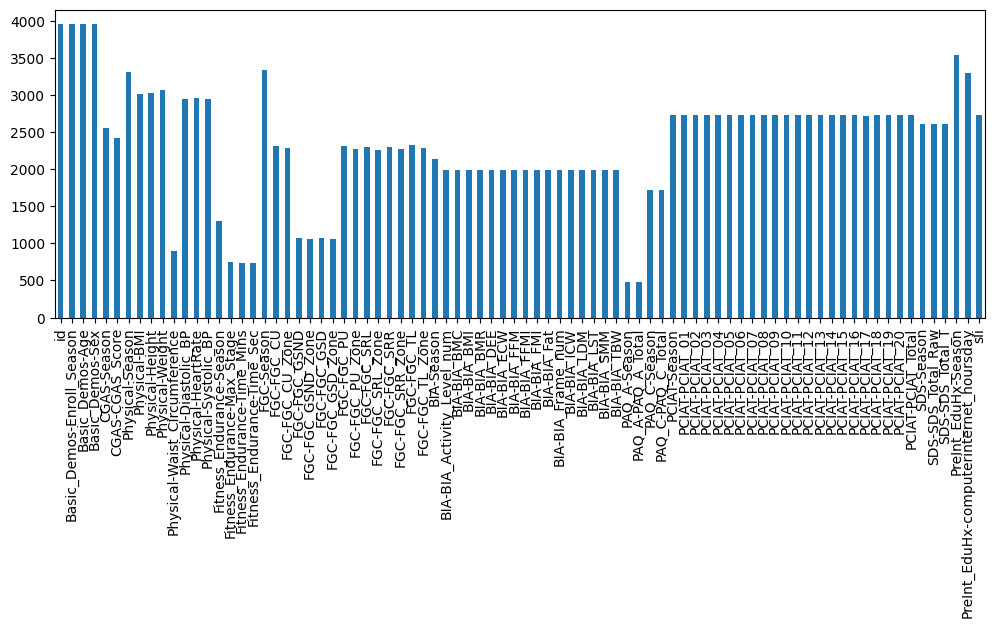

In [19]:
counts = df_train.count()

plt.figure(figsize=(12,4))
counts.plot(kind='bar')
plt.show()

In [20]:
# Total number of rows with sii values present
# df_train_labelled = df_train[df_train['sii'].notna()]
# print("Number of rows with SII values present: ", df_train_labelled.shape)

In [21]:
# # Total number of rows with sii values absent / as NaN
# df_train_unlabelled = df_train[df_train['sii'].isna()]
# print("Number of rows with SII values absent:", df_train_unlabelled.shape)

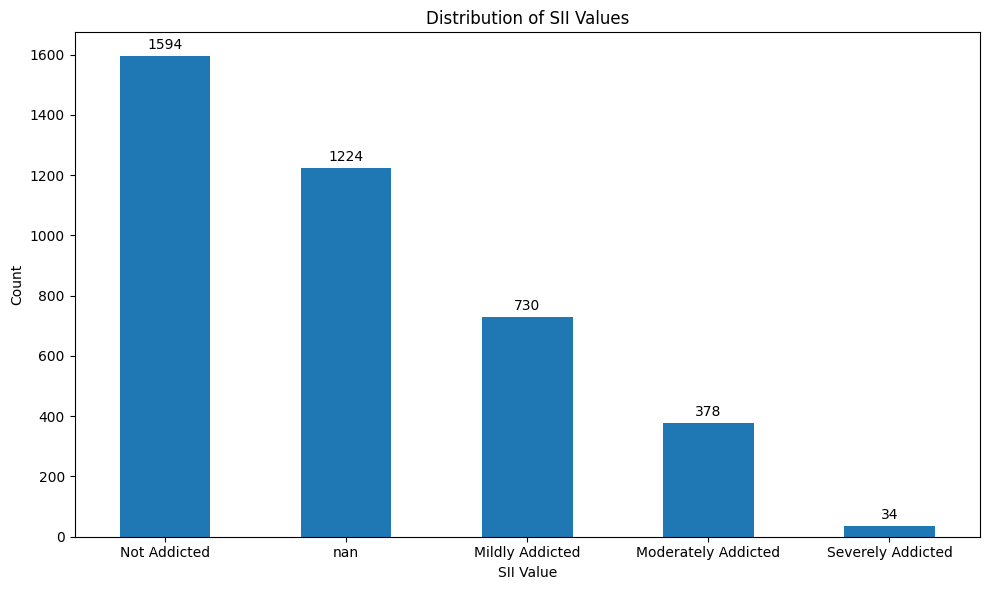

In [22]:
plt.figure(figsize=(10,6))
ax = df_train['sii'].value_counts(dropna=False).plot(kind='bar')

# Add value labels on top of each bar
for i in ax.containers:
   ax.bar_label(i, padding=3)

plt.title('Distribution of SII Values')
plt.xlabel('SII Value')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [23]:
nan_percentage = (df_train.isna().sum()/len(df_train))*100
print("Percentage of NaN values in each column:\n", nan_percentage)

Percentage of NaN values in each column:
 id                                         0.000000
Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                               35.479798
                                            ...    
SDS-SDS_Total_Raw                         34.116162
SDS-SDS_Total_T                           34.191919
PreInt_EduHx-Season                       10.606061
PreInt_EduHx-computerinternet_hoursday    16.641414
sii                                       30.909091
Length: 82, dtype: float64


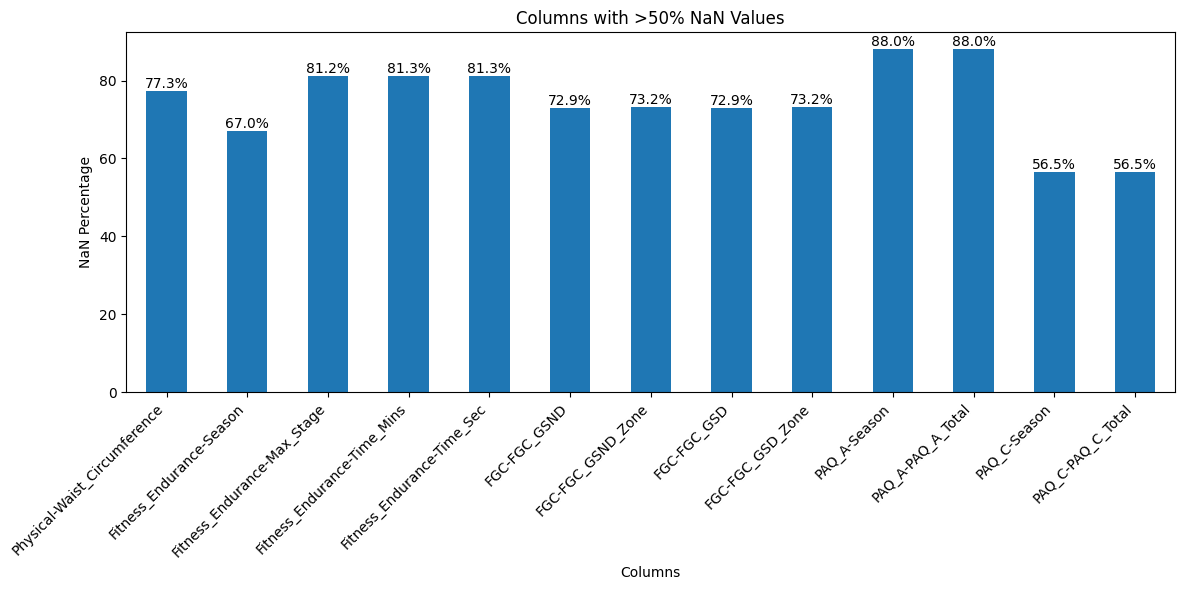

In [24]:
plt.figure(figsize=(12, 6))

high_nan = nan_percentage[nan_percentage > 50]

# Plot
ax = high_nan.plot(kind='bar')

for i in range(len(high_nan)):
   plt.text(i, high_nan[i], f'{high_nan[i]:.1f}%', ha='center', va='bottom')

plt.title('Columns with >50% NaN Values')
plt.xlabel('Columns')
plt.ylabel('NaN Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Removing columns with more than 80% rows missing

In [25]:
df_train = df_train.loc[:, nan_percentage <= 80]
df_train.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,Male,Winter,51.0,Fall,16.877316,46.0,50.8,...,Often,Occasionally,Often,55.0,NaN,NaN,NaN,Fall,More than 3hs/day,Moderately Addicted
1,000fd460,Summer,9,Male,NaN,NaN,Fall,14.035590,48.0,46.0,...,Does Not Apply,Does Not Apply,Does Not Apply,0.0,Fall,46.0,64.0,Summer,Less than 1h/day,Not Addicted
2,105258,Summer,10,Female,Fall,71.0,Fall,16.648696,56.5,75.6,...,Occasionally,Rarely,Rarely,28.0,Fall,38.0,54.0,Summer,Around 2hs/day,Not Addicted
3,00115b9f,Winter,9,Male,Fall,71.0,Summer,18.292347,56.0,81.6,...,Frequently,Often,Rarely,44.0,Summer,31.0,45.0,Winter,Less than 1h/day,Mildly Addicted
4,0016bb22,Spring,18,Female,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_train.shape

(3960, 77)

## Removing outliers

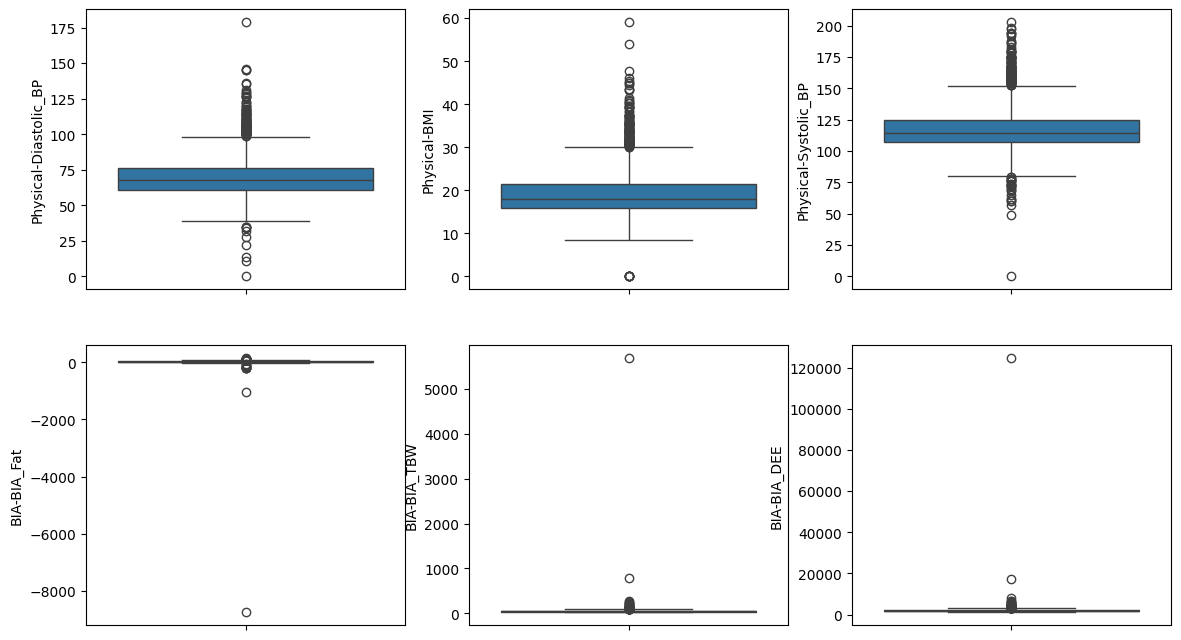

In [27]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.boxplot(y=df_train['Physical-Diastolic_BP'], ax=ax1)
sns.boxplot(y=df_train['Physical-BMI'], ax=ax2)
sns.boxplot(y=df_train['Physical-Systolic_BP'], ax=ax3)
sns.boxplot(y=df_train['BIA-BIA_Fat'], ax=ax4)
sns.boxplot(y=df_train['BIA-BIA_TBW'], ax=ax5)
sns.boxplot(y=df_train['BIA-BIA_DEE'], ax=ax6)

plt.show()

In [28]:
columns_to_drop_for_outlier_removal = ['id',
'Basic_Demos-Enroll_Season',
'Basic_Demos-Sex',
'CGAS-Season',
'Physical-Season',
'Fitness_Endurance-Season',
'FGC-Season',
'FGC-FGC_CU_Zone',
'FGC-FGC_GSND_Zone',
'FGC-FGC_GSD_Zone',
'FGC-FGC_PU_Zone',
'FGC-FGC_SRL_Zone',
'FGC-FGC_SRR_Zone',
'FGC-FGC_TL_Zone',
'BIA-Season',
'BIA-BIA_Activity_Level_num',
'BIA-BIA_Frame_num',
'PAQ_C-Season',
'SDS-Season',
'PreInt_EduHx-Season',
'PreInt_EduHx-computerinternet_hoursday', 'PCIAT-Season',
'PCIAT-PCIAT_01',
'PCIAT-PCIAT_02',
'PCIAT-PCIAT_03',
'PCIAT-PCIAT_04',
'PCIAT-PCIAT_05',
'PCIAT-PCIAT_06',
'PCIAT-PCIAT_07',
'PCIAT-PCIAT_08',
'PCIAT-PCIAT_09',
'PCIAT-PCIAT_10',
'PCIAT-PCIAT_11',
'PCIAT-PCIAT_12',
'PCIAT-PCIAT_13',
'PCIAT-PCIAT_14',
'PCIAT-PCIAT_15',
'PCIAT-PCIAT_16',
'PCIAT-PCIAT_17',
'PCIAT-PCIAT_18',
'PCIAT-PCIAT_19',
'PCIAT-PCIAT_20',
'sii']

In [29]:
clean_df, removed = remove_outliers_iqr(df_train, df_train.drop(columns_to_drop_for_outlier_removal, axis=1).columns)
print("Number of rows removed: ",removed)

Number of rows removed:  98


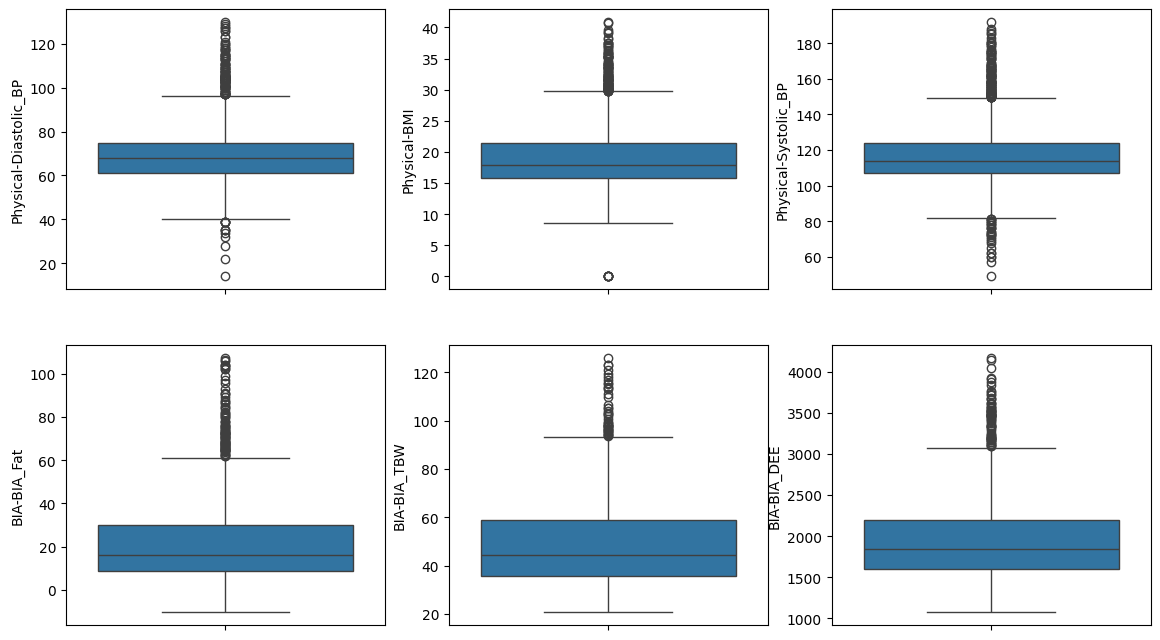

In [30]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

sns.boxplot(y=clean_df['Physical-Diastolic_BP'], ax=ax1)
sns.boxplot(y=clean_df['Physical-BMI'], ax=ax2)
sns.boxplot(y=clean_df['Physical-Systolic_BP'], ax=ax3)
sns.boxplot(y=clean_df['BIA-BIA_Fat'], ax=ax4)
sns.boxplot(y=clean_df['BIA-BIA_TBW'], ax=ax5)
sns.boxplot(y=clean_df['BIA-BIA_DEE'], ax=ax6)

plt.show()

## Dividing Data into X and Y columns

In [31]:
y = clean_df[['sii']]
X = clean_df.drop(columns=['sii'])

In [32]:
X.shape, y.shape

((3862, 76), (3862, 1))

## Data Imputation

In [33]:
def impute_data(df):
    # Create a copy to avoid modifying original
    df_imputed = df.copy()

    # Store original index
    original_index = df_imputed.index

    # Initialize imputers
    knn_imputer = KNNImputer(n_neighbors=5)

    # Separate numeric and categorical columns
    numeric_columns = df_imputed.select_dtypes(include=['int64', 'float64']).columns
    categorical_columns = df_imputed.select_dtypes(exclude=['int64', 'float64']).columns

    # Handle numeric columns
    if len(numeric_columns) > 0:
        df_imputed[numeric_columns] = knn_imputer.fit_transform(df_imputed[numeric_columns])

    # Handle categorical columns
    for column in categorical_columns:
        mode_value = df_imputed[column].mode()[0]
        df_imputed[column].fillna(mode_value, inplace=True)

    # Ensure we maintain the original index
    df_imputed.index = original_index

    # Verify shape
    print(f"Original shape: {df.shape}")
    print(f"Imputed shape: {df_imputed.shape}")

    return df_imputed
# Apply imputation
X_train = impute_data(X)

Original shape: (3862, 76)
Imputed shape: (3862, 76)


In [34]:
X_train.describe()

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,...,BIA-BIA_Fat,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_C-PAQ_C_Total,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T
count,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,...,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,10.366649,64.924340,18.913417,56.049939,88.823184,27.103071,69.350440,81.523511,116.742879,11.192957,...,22.696292,31.204122,17.648432,63.270624,30.985059,49.857809,2.538215,28.254738,41.472242,58.039151
std,3.542645,9.889352,4.849400,7.370251,40.963760,4.406724,11.578436,12.074780,14.865157,9.159918,...,15.587628,8.565451,6.438361,22.343030,12.436442,17.038088,0.553048,17.783826,9.458605,11.813496
min,5.000000,25.000000,0.000000,36.000000,0.000000,18.000000,14.000000,33.000000,49.000000,0.000000,...,-10.411300,14.489000,4.635810,23.620100,4.655730,20.589200,0.580000,0.000000,17.000000,38.000000
25%,8.000000,60.000000,15.976267,50.350000,59.200000,23.500000,62.000000,74.000000,107.800000,4.850000,...,10.923675,23.821305,12.070125,44.131575,20.701425,36.108820,2.252000,17.000000,35.200000,50.000000
50%,10.000000,65.000000,17.956748,55.000000,77.000000,26.400000,68.200000,81.000000,115.000000,9.200000,...,17.741051,28.785000,16.369980,56.572080,27.905640,44.731130,2.478000,28.000000,39.000000,55.400000
75%,13.000000,70.600000,21.333006,62.000000,114.200000,29.800000,74.000000,88.000000,124.000000,16.000000,...,32.305320,36.216995,22.231720,79.148550,39.359760,62.050440,2.772000,37.000000,45.150000,63.000000
max,22.000000,95.000000,40.898793,78.000000,267.200000,49.000000,130.000000,138.000000,192.000000,60.000000,...,107.305000,69.932100,47.274200,164.676000,94.938700,125.956000,4.790000,92.000000,85.000000,100.000000


In [35]:
X_train.shape

(3862, 76)

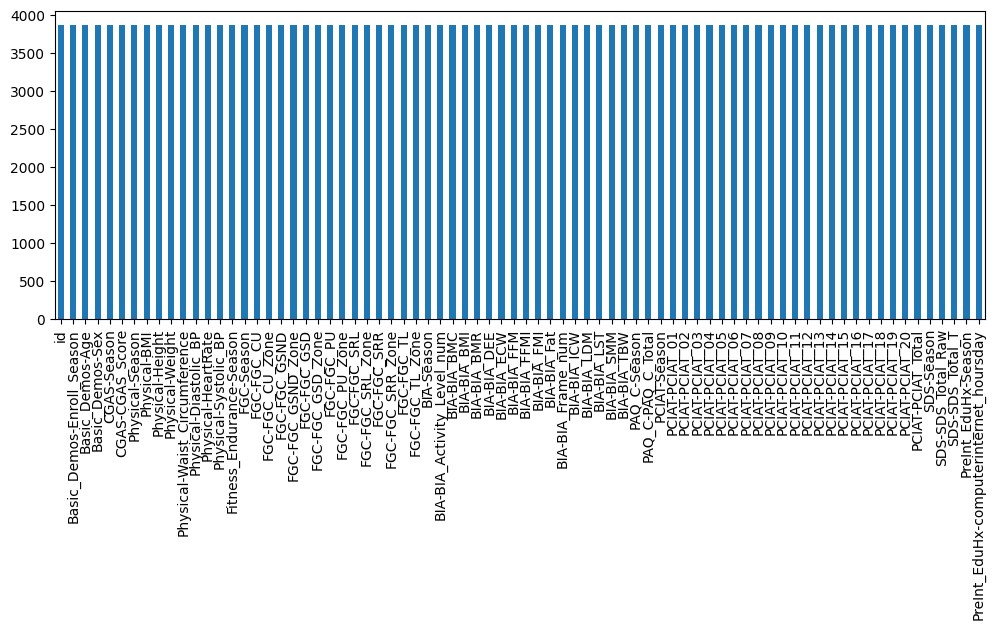

In [36]:
counts = X_train.count()

plt.figure(figsize=(12,4))
counts.plot(kind='bar')
plt.show()

## Encoding the Columns

In [37]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col != 'id']
print(categorical_columns)

['Basic_Demos-Enroll_Season', 'Basic_Demos-Sex', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PAQ_C-Season', 'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'SDS-Season', 'PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']


In [38]:
X_train.shape

(3862, 76)

In [39]:
ordinal_columns = ['Basic_Demos-Sex', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_Frame_num', 'PreInt_EduHx-computerinternet_hoursday', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20']
onehot_columns = [col for col in categorical_columns if col not in ordinal_columns]

In [40]:
# Define the feature encodings
x_encodings = {
    # Basic Demographics
    'Basic_Demos-Sex': {'Male': 0, 'Female': 1},
    
    # FitnessGram Child Tests
    'FGC-FGC_CU_Zone': {'Needs Improvement': 0, 'Healthy Fitness Zone': 1},
    'FGC-FGC_GSND_Zone': {'Weak': 1, 'Normal': 2, 'Strong': 3},
    'FGC-FGC_GSD_Zone': {'Weak': 1, 'Normal': 2, 'Strong': 3},
    'FGC-FGC_PU_Zone': {'Needs Improvement': 0, 'Healthy Fitness Zone': 1},
    'FGC-FGC_SRL_Zone': {'Needs Improvement': 0, 'Healthy Fitness Zone': 1},
    'FGC-FGC_SRR_Zone': {'Needs Improvement': 0, 'Healthy Fitness Zone': 1},
    'FGC-FGC_TL_Zone': {'Needs Improvement': 0, 'Healthy Fitness Zone': 1},
    
    # Bio-electric Impedance Analysis
    'BIA-BIA_Activity_Level_num': {'Very Light': 1, 'Light': 2, 'Moderate': 3, 'Heavy': 4, 'Exceptional': 5},
    'BIA-BIA_Frame_num': {'Small': 1, 'Medium': 2, 'Large': 3},
    
    # Internet Usage
    'PreInt_EduHx-computerinternet_hoursday': {'Less than 1h/day': 0, 'Around 1h/day': 1, 'Around 2hs/day': 2, 'More than 3hs/day': 3},
    
    # Parent-Child Internet Addiction Test
    'PCIAT-PCIAT_01': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_02': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_03': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_04': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_05': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_06': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_07': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_08': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_09': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_10': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_11': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_12': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_13': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_14': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_15': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_16': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_17': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_18': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_19': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5},
    'PCIAT-PCIAT_20': {'Does Not Apply': 0, 'Rarely': 1, 'Occasionally': 2, 'Frequently': 3, 'Often': 4, 'Always': 5}
}

# Define target encoding
y_encodings = {'sii': {'Not Addicted': 0, 'Mildly Addicted': 1, 'Moderately Addicted': 2, 'Severely Addicted': 3}}

In [41]:
# Function to encode a single column
def encode_column(series, mapping):
    return series.map(lambda x: mapping.get(x, x))

# Encode features (X)
for col in ordinal_columns:
    if col in x_encodings:
        X_train[col] = encode_column(X_train[col], x_encodings[col])

# Encode target (y)
y_train = y.replace({'sii': y_encodings['sii']})

# Check encoded values
print("\nSample of encoded X_train:")
print(X_train[ordinal_columns].head())
print("\nUnique values in encoded y_train:")
print(y_train['sii'].value_counts())


Sample of encoded X_train:
   Basic_Demos-Sex  FGC-FGC_CU_Zone  FGC-FGC_GSND_Zone  FGC-FGC_GSD_Zone  \
0                0                0                  2                 2   
1                0                0                  2                 2   
2                1                1                  1                 2   
3                0                1                  2                 2   
4                1                0                  2                 2   

   FGC-FGC_PU_Zone  FGC-FGC_SRL_Zone  FGC-FGC_SRR_Zone  FGC-FGC_TL_Zone  \
0                0                 0                 0                1   
1                0                 1                 1                0   
2                1                 1                 1                0   
3                0                 0                 0                1   
4                0                 1                 1                1   

   BIA-BIA_Activity_Level_num  BIA-BIA_Frame_num  ...  PCIAT-PCI

In [42]:
X_train.shape

(3862, 76)

In [43]:
original_index = X_train.index

# Fit and transform OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Use sparse_output instead of sparse
encoded_columns = encoder.fit_transform(X_train[onehot_columns])

# Create DataFrame with encoded columns and original index
encoded_columns_df = pd.DataFrame(
    encoded_columns, 
    columns=encoder.get_feature_names_out(onehot_columns),
    index=original_index  # Important: Use original index
)

# Drop original columns and concatenate
X_train = X_train.drop(columns=onehot_columns)
X_train = pd.concat([X_train, encoded_columns_df], axis=1)

# Verify shapes
print("Original index length:", len(original_index))
print("Final X_train shape:", X_train.shape)

Original index length: 3862
Final X_train shape: (3862, 106)


In [44]:
X_train.shape

(3862, 106)

In [45]:
X_train.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PCIAT-Season_Summer,PCIAT-Season_Winter,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
0,00008ff9,5.0,0,51.0,16.877316,46.00,50.8,23.0,61.6,84.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,000fd460,9.0,0,65.8,14.035590,48.00,46.0,22.0,75.0,70.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,105258,10.0,1,71.0,16.648696,56.50,75.6,24.4,65.0,94.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,00115b9f,9.0,0,71.0,18.292347,56.00,81.6,26.2,60.0,97.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0016bb22,18.0,1,57.4,24.147831,65.07,168.6,35.0,69.4,72.8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [46]:
X_train = X_train.drop('id',axis=1)

X_train.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,PCIAT-Season_Summer,PCIAT-Season_Winter,SDS-Season_Fall,SDS-Season_Spring,SDS-Season_Summer,SDS-Season_Winter,PreInt_EduHx-Season_Fall,PreInt_EduHx-Season_Spring,PreInt_EduHx-Season_Summer,PreInt_EduHx-Season_Winter
count,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,...,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,10.366649,0.373382,64.924340,18.913417,56.049939,88.823184,27.103071,69.350440,81.523511,116.742879,...,0.165717,0.160798,0.155619,0.521233,0.160798,0.162351,0.206888,0.358364,0.205334,0.229415
std,3.542645,0.483765,9.889352,4.849400,7.370251,40.963760,4.406724,11.578436,12.074780,14.865157,...,0.371875,0.367392,0.362541,0.499614,0.367392,0.368820,0.405127,0.479582,0.403998,0.420511
min,5.000000,0.000000,25.000000,0.000000,36.000000,0.000000,18.000000,14.000000,33.000000,49.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,60.000000,15.976267,50.350000,59.200000,23.500000,62.000000,74.000000,107.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,0.000000,65.000000,17.956748,55.000000,77.000000,26.400000,68.200000,81.000000,115.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.000000,1.000000,70.600000,21.333006,62.000000,114.200000,29.800000,74.000000,88.000000,124.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,22.000000,1.000000,95.000000,40.898793,78.000000,267.200000,49.000000,130.000000,138.000000,192.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
y.shape
y.describe()

,sii
count,2658
unique,4
top,Not Addicted
freq,1561


## Standardizing and Normalizing Data

In [48]:
categorical_columns = ['FGC-FGC_CU_Zone','FGC-FGC_GSND_Zone','FGC-FGC_GSD_Zone','FGC-FGC_PU_Zone','FGC-FGC_SRL_Zone','FGC-FGC_SRR_Zone','FGC-FGC_TL_Zone',
'BIA-BIA_Activity_Level_num',
'Basic_Demos-Enroll_Season_Fall','Basic_Demos-Enroll_Season_Spring',
'Basic_Demos-Enroll_Season_Summer','Basic_Demos-Enroll_Season_Winter',
'Basic_Demos-Sex',
'CGAS-Season_Fall','CGAS-Season_Spring','CGAS-Season_Summer','CGAS-Season_Winter',
'Physical-Season_Fall','Physical-Season_Spring','Physical-Season_Summer','Physical-Season_Winter',
'Fitness_Endurance-Season_Fall','Fitness_Endurance-Season_Spring','Fitness_Endurance-Season_Summer','Fitness_Endurance-Season_Winter',
'FGC-Season_Fall','FGC-Season_Spring','FGC-Season_Summer','FGC-Season_Winter',
'BIA-Season_Fall','BIA-Season_Spring','BIA-Season_Summer','BIA-Season_Winter',
'PAQ_C-Season_Fall','PAQ_C-Season_Spring','PAQ_C-Season_Summer','PAQ_C-Season_Winter',
'SDS-Season_Fall','SDS-Season_Spring','SDS-Season_Summer','SDS-Season_Winter',
'PreInt_EduHx-Season_Fall','PreInt_EduHx-Season_Spring','PreInt_EduHx-Season_Summer','PreInt_EduHx-Season_Winter',
'PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03',
'PCIAT-PCIAT_04','PCIAT-PCIAT_05','PCIAT-PCIAT_06',
'PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09',
'PCIAT-PCIAT_10','PCIAT-PCIAT_11','PCIAT-PCIAT_12',
'PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15',
'PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18',
'PCIAT-PCIAT_19','PCIAT-PCIAT_20',]

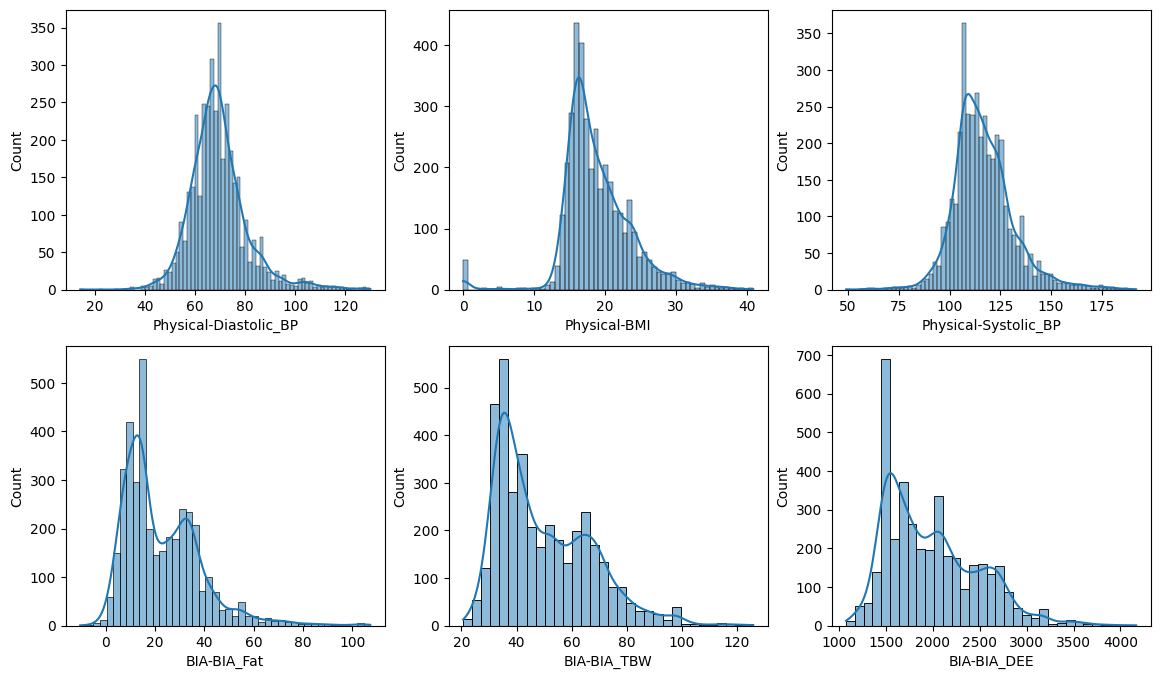

In [49]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=X_train['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=X_train['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=X_train['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=X_train['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=X_train['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=X_train['BIA-BIA_DEE'], ax=ax6)
plt.show()

### Standardization

In [50]:
scaled_X_train = StandardScale(X_train, categorical_columns)
scaled_X_train.describe()

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,...,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20
count,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,3.862000e+03,...,3862.000000,3862.00000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,-2.134204e-16,-2.171001e-16,-8.463223e-17,-1.030305e-16,1.453466e-16,4.599578e-16,-8.729998e-16,-6.954561e-16,3.624467e-16,1.002708e-16,...,1.145003,0.16261,0.917141,0.702486,1.022527,0.996893,1.112895,1.107716,0.792077,0.643967
std,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,1.000129e+00,...,1.487825,0.43419,1.322948,1.169096,1.414492,1.408521,1.413918,1.469820,1.235120,1.068425
min,-1.515067e+00,-4.037626e+00,-3.900661e+00,-2.720740e+00,-2.168617e+00,-2.065991e+00,-4.781096e+00,-4.019104e+00,-4.557749e+00,-1.222108e+00,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.681325e-01,-4.980081e-01,-6.057513e-01,-7.734713e-01,-7.232495e-01,-8.177362e-01,-6.349210e-01,-6.231572e-01,-6.016780e-01,-6.925584e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.035094e-01,7.651672e-03,-1.973014e-01,-1.424749e-01,-2.886628e-01,-1.595657e-01,-9.937346e-02,-4.336137e-02,-1.172611e-01,-2.176018e-01,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.434253e-01,5.739906e-01,4.990105e-01,8.074123e-01,6.195745e-01,6.120824e-01,4.016226e-01,5.364344e-01,4.882599e-01,5.248590e-01,...,2.000000,0.00000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000
max,3.284229e+00,3.041610e+00,4.534215e+00,2.978583e+00,4.355067e+00,4.969625e+00,5.238826e+00,4.677833e+00,5.063308e+00,5.329017e+00,...,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


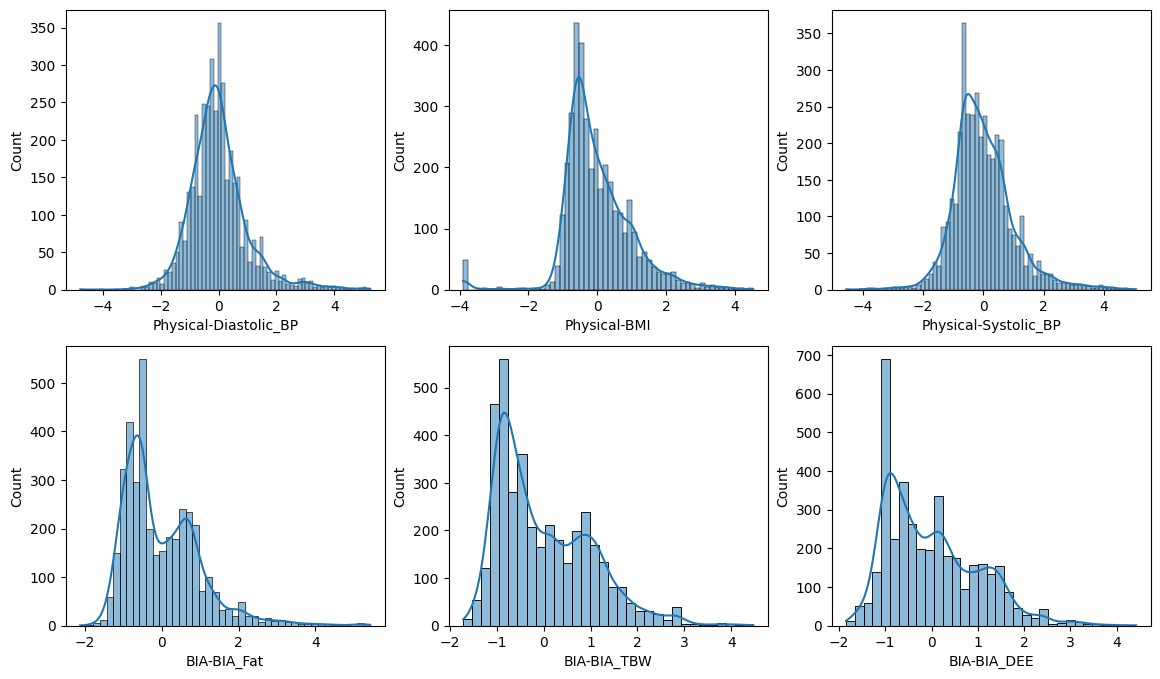

In [51]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=scaled_X_train['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=scaled_X_train['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=scaled_X_train['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=scaled_X_train['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=scaled_X_train['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=scaled_X_train['BIA-BIA_DEE'], ax=ax6)
plt.show()

### Normalization

In [52]:
normalized_X_train = MinMaxScale(X_train, categorical_columns)
normalized_X_train.describe()

,Basic_Demos-Age,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,...,PCIAT-PCIAT_11,PCIAT-PCIAT_12,PCIAT-PCIAT_13,PCIAT-PCIAT_14,PCIAT-PCIAT_15,PCIAT-PCIAT_16,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20
count,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,...,3862.000000,3862.00000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000,3862.000000
mean,0.315685,0.570348,0.462444,0.477380,0.332422,0.293647,0.477159,0.462129,0.473726,0.186549,...,1.145003,0.16261,0.917141,0.702486,1.022527,0.996893,1.112895,1.107716,0.792077,0.643967
std,0.208391,0.141276,0.118571,0.175482,0.153307,0.142152,0.099814,0.114998,0.103952,0.152665,...,1.487825,0.43419,1.322948,1.169096,1.414492,1.408521,1.413918,1.469820,1.235120,1.068425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.176471,0.500000,0.390629,0.341667,0.221557,0.177419,0.413793,0.390476,0.411189,0.080833,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.294118,0.571429,0.439053,0.452381,0.288174,0.270968,0.467241,0.457143,0.461538,0.153333,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.470588,0.651429,0.521605,0.619048,0.427395,0.380645,0.517241,0.523810,0.524476,0.266667,...,2.000000,0.00000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


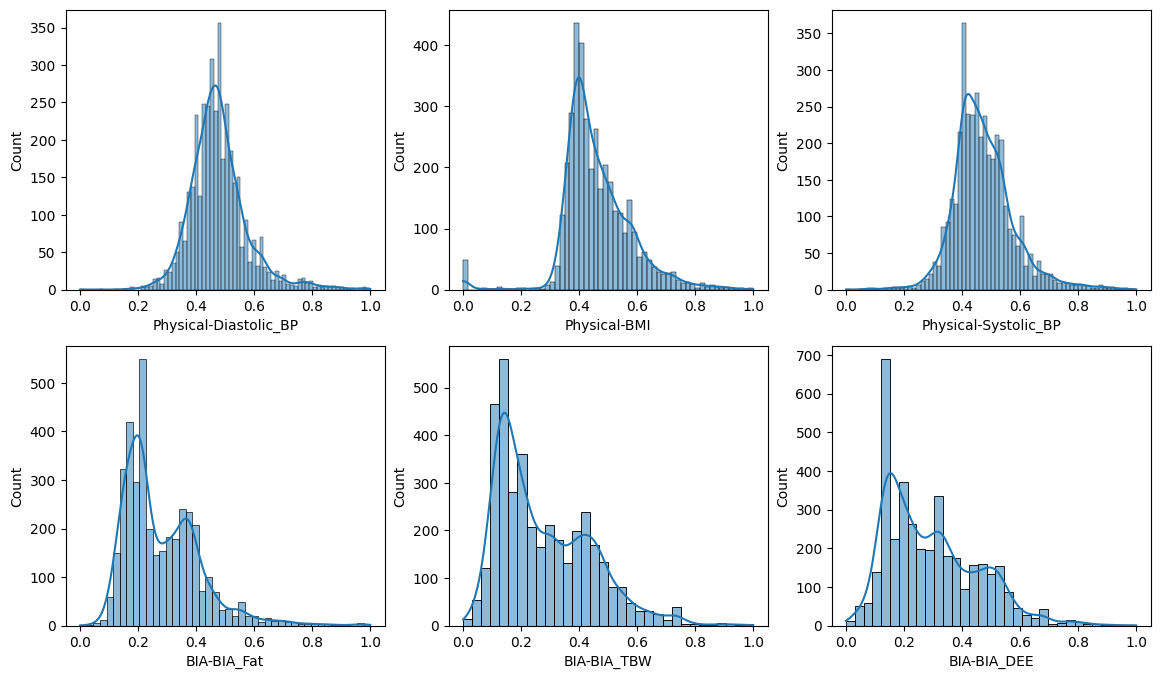

In [53]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))
sns.histplot(kde=True, x=normalized_X_train['Physical-Diastolic_BP'], ax=ax1)
sns.histplot(kde=True, x=normalized_X_train['Physical-BMI'], ax=ax2)
sns.histplot(kde=True, x=normalized_X_train['Physical-Systolic_BP'], ax=ax3)
sns.histplot(kde=True, x=normalized_X_train['BIA-BIA_Fat'], ax=ax4)
sns.histplot(kde=True, x=normalized_X_train['BIA-BIA_TBW'], ax=ax5)
sns.histplot(kde=True, x=normalized_X_train['BIA-BIA_DEE'], ax=ax6)
plt.show()

# Feature Engineering

## Correlation

In [54]:
corr_col_1 = ['Basic_Demos-Sex', 'Basic_Demos-Age', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height',
 'Physical-Weight', 'Physical-Diastolic_BP', 'Physical-HeartRate',
 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU',
 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_BMC',
 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW',
 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',
 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone',
 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone',
 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num', 'sii']

corr_col_2 = ['Basic_Demos-Enroll_Season_Fall', 'Basic_Demos-Enroll_Season_Spring',
 'Basic_Demos-Enroll_Season_Summer', 'Basic_Demos-Enroll_Season_Winter','CGAS-Season_Fall',
 'CGAS-Season_Spring', 'CGAS-Season_Summer', 'CGAS-Season_Winter',
 'Physical-Season_Fall', 'Physical-Season_Spring',
 'Physical-Season_Summer', 'Physical-Season_Winter',
 'Fitness_Endurance-Season_Fall', 'Fitness_Endurance-Season_Spring',
 'Fitness_Endurance-Season_Summer', 'Fitness_Endurance-Season_Winter',
 'FGC-Season_Fall', 'FGC-Season_Spring', 'FGC-Season_Summer',
 'FGC-Season_Winter', 'BIA-Season_Fall', 'BIA-Season_Spring',
 'BIA-Season_Summer', 'BIA-Season_Winter', 'PAQ_C-Season_Fall',
 'PAQ_C-Season_Spring', 'PAQ_C-Season_Summer', 'PAQ_C-Season_Winter',
 'SDS-Season_Fall', 'SDS-Season_Spring', 'SDS-Season_Summer',
 'SDS-Season_Winter', 'PreInt_EduHx-Season_Fall',
 'PreInt_EduHx-Season_Spring', 'PreInt_EduHx-Season_Summer',
 'PreInt_EduHx-Season_Winter', 'sii']

corr_col_3 = ['PCIAT-PCIAT_01','PCIAT-PCIAT_02','PCIAT-PCIAT_03','PCIAT-PCIAT_04','PCIAT-PCIAT_05','PCIAT-PCIAT_06','PCIAT-PCIAT_07','PCIAT-PCIAT_08','PCIAT-PCIAT_09','PCIAT-PCIAT_10','PCIAT-PCIAT_11','PCIAT-PCIAT_12','PCIAT-PCIAT_13','PCIAT-PCIAT_14','PCIAT-PCIAT_15','PCIAT-PCIAT_16','PCIAT-PCIAT_17','PCIAT-PCIAT_18','PCIAT-PCIAT_19','PCIAT-PCIAT_20','PCIAT-PCIAT_Total','sii']

In [55]:
temp_df = pd.concat([scaled_X_train, y_train], axis=1)

In [56]:
%%skip
correlation_heatmap(temp_df[corr_col_1], x=24, y=24, dpi=412)

In [57]:
%%skip
correlation_heatmap(temp_df[corr_col_2], x=24, y=24, dpi=412)

In [58]:
%%skip
correlation_heatmap(temp_df[corr_col_3], x=24, y=24, dpi=412)

In [59]:
%%skip
threshold = 0.91
correlation_matrix = X_train.corr()
high_corr_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = high_corr_pairs[high_corr_pairs < 1] # removing self correlations
high_corr_pairs = high_corr_pairs[high_corr_pairs > threshold]

print("Highly correlated feature pairs (correlation > 0.9):\n")
print(high_corr_pairs)

In [60]:
%%skip
features_to_drop = set()
for feature1, feature2 in high_corr_pairs.index:
    if feature1 not in features_to_drop and feature2 not in features_to_drop:
        # Drop one feature (arbitrarily choose feature2)
        features_to_drop.add(feature2)

print(f"Number of columns to drop: {len(features_to_drop)}")
print(f"Columns to drop: {features_to_drop}")

In [61]:
%%skip
X_train = X_train.drop(columns=list(features_to_drop))
X_train.shape

In [62]:
%%skip
type(y)
y_squeezed = y.squeeze()

In [63]:
%%skip
from sklearn.feature_selection import chi2, f_classif
from scipy.stats import pearsonr
import pandas as pd

# Function to calculate feature importance
def calculate_feature_importance(X_train, y):
    feature_scores = []
    
    # Make sure y is a 1D array-like structure (like a Series)
    y = y.values if isinstance(y, pd.DataFrame) else y  # In case y is a DataFrame, convert to array
    
    for column in X_train.columns:
        if X_train[column].dtype == 'object':  # X column is categorical
            if y.dtype == 'object':  # Both X and y are categorical
                chi2_score, _ = chi2(X_train[[column]], y)
                feature_scores.append((column, chi2_score[0], 'Chi-Square'))
            else:  # X is categorical, y is numerical
                f_stat, _ = f_classif(X_train[[column]], y)
                feature_scores.append((column, f_stat[0], 'F-Statistic'))
        else:  # X column is numerical
            if y.dtype != 'object':  # Both X and y are numerical
                corr, _ = pearsonr(X_train[column], y)
                feature_scores.append((column, abs(corr), 'Pearson R'))
            else:  # X is numerical, y is categorical
                f_stat, _ = f_classif(X_train[[column]], y)
                feature_scores.append((column, f_stat[0], 'F-Statistic'))
    
    # Create a DataFrame for results
    importance_df = pd.DataFrame(feature_scores, columns=['Feature', 'Score', 'Method'])
    return importance_df.sort_values(by='Score', ascending=False)

# Calculate feature importance
importance_df = calculate_feature_importance(X_train, y_squeezed)

In [64]:
%%skip
print('Importance of features: \n', importance_df)

# Supervised Learning

## Split Data

In [65]:
# Create mask for non-NaN values in sii column
mask = ~y_train['sii'].isna()

# Apply mask to both X_train and y_train 
X_train_clean = scaled_X_train[mask].drop('PCIAT-PCIAT_Total', axis=1)
y_train_clean = y_train[mask]

# First split: separate test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(X_train_clean, y_train_clean, test_size=0.1, random_state=42)

# Second split: divide remaining data into train and CV (0.8 * 0.8 = 0.64 for train, 0.8 * 0.2 = 0.16 for CV)
X_train_split, X_cv, y_train_split, y_cv = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

print(f"Training set shape: {X_train_split.shape}")
print(f"CV set shape: {X_cv.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (2152, 104)
CV set shape: (240, 104)
Test set shape: (266, 104)


In [80]:
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train_split['sii'])

## XGBoost

In [81]:

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric=['merror', 'mlogloss'],
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_split, 
    y_train_split,
    eval_set=[(X_test, y_test)],
    verbose=True
)

[0]	validation_0-merror:0.16541	validation_0-mlogloss:1.25704
[1]	validation_0-merror:0.16917	validation_0-mlogloss:1.15044
[2]	validation_0-merror:0.16917	validation_0-mlogloss:1.06212
[3]	validation_0-merror:0.16917	validation_0-mlogloss:0.98544
[4]	validation_0-merror:0.16165	validation_0-mlogloss:0.91845
[5]	validation_0-merror:0.16541	validation_0-mlogloss:0.85683
[6]	validation_0-merror:0.15789	validation_0-mlogloss:0.80461
[7]	validation_0-merror:0.15414	validation_0-mlogloss:0.75849
[8]	validation_0-merror:0.15414	validation_0-mlogloss:0.71754
[9]	validation_0-merror:0.14662	validation_0-mlogloss:0.67831
[10]	validation_0-merror:0.14662	validation_0-mlogloss:0.64145
[11]	validation_0-merror:0.14286	validation_0-mlogloss:0.61004
[12]	validation_0-merror:0.14662	validation_0-mlogloss:0.58085
[13]	validation_0-merror:0.13910	validation_0-mlogloss:0.55411
[14]	validation_0-merror:0.12406	validation_0-mlogloss:0.52903
[15]	validation_0-merror:0.13534	validation_0-mlogloss:0.50677
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [67]:
# Make predictions
y_pred = xgb_model.predict(X_cv)

# Print model performance
print("\nModel Accuracy:", accuracy_score(y_cv, y_pred))


Model Accuracy: 0.9125


In [68]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_cv, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96       148
         1.0       0.82      0.90      0.85        59
         2.0       0.79      0.93      0.85        28
         3.0       1.00      0.40      0.57         5

    accuracy                           0.91       240
   macro avg       0.90      0.79      0.81       240
weighted avg       0.92      0.91      0.91       240



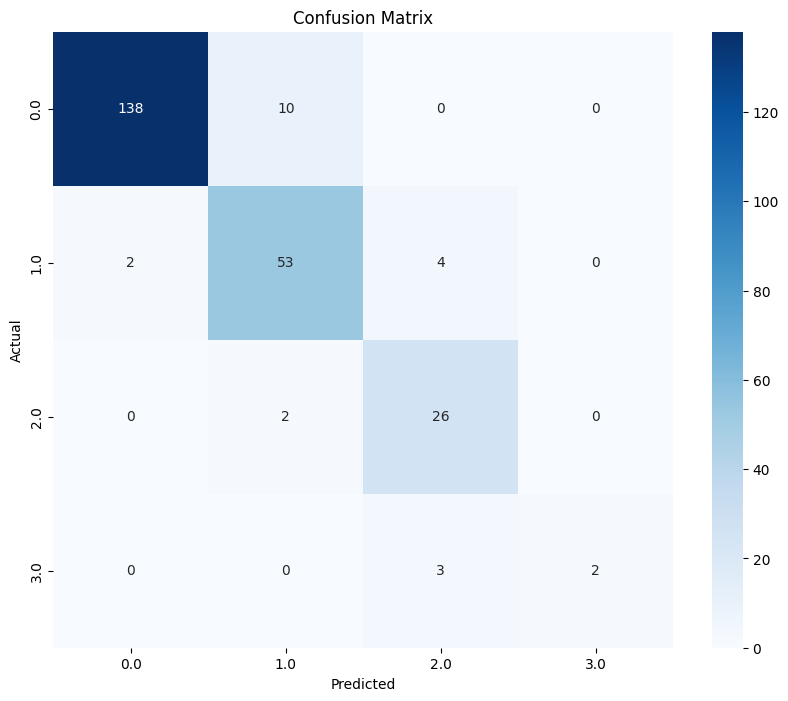

In [69]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_cv, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

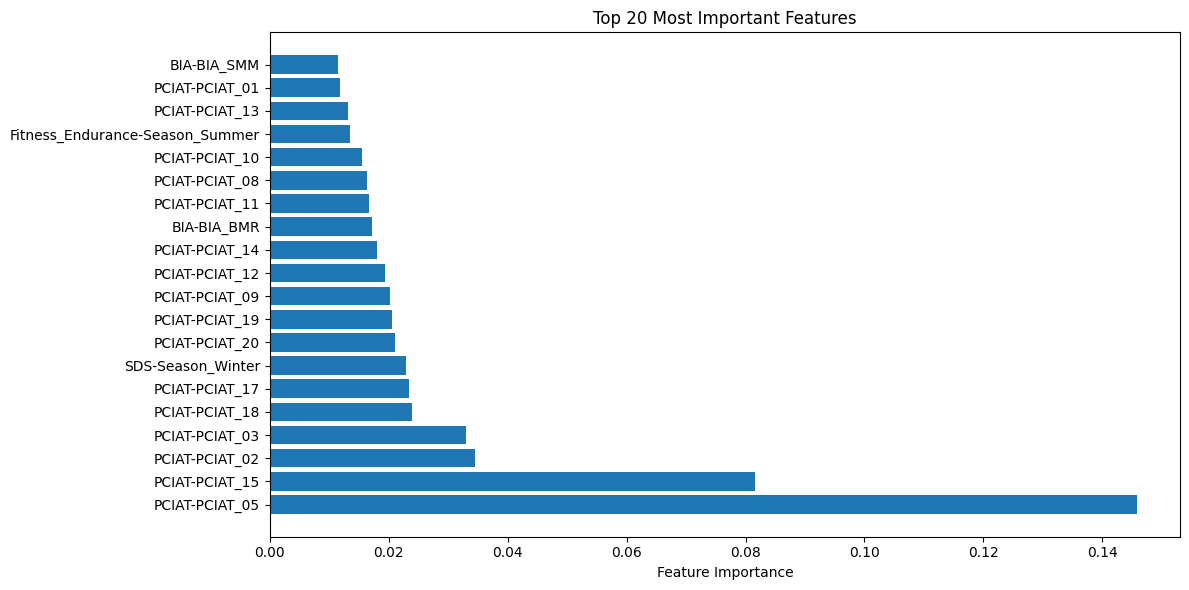

In [70]:
# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': X_train_split.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

In [71]:
%%skip
# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['sii'])

# Print encoded classes for verification
print("Classes:", label_encoder.classes_)
print("Encoded values:", np.unique(y_encoded))

# Split the data
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric=['merror', 'mlogloss'],
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_split, 
    y_train_split,
    eval_set=[(X_test_split, y_test_split)],
    verbose=True
)


# Make predictions
y_pred = xgb_model.predict(X_test_split)

# Print model performance
print("\nModel Accuracy:", accuracy_score(y_test_split, y_pred))

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_split, y_pred, 
                          target_names=label_encoder.classes_))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_split, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Save feature importance to a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

## GridSearchCV for XGBoost

In [72]:
%%skip
param_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_split, y_train_split)
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

In [73]:
%%skip
def optimize_xgboost_model(X_train, y_train, X_test, y_test):
    """
    Complete pipeline for XGBoost optimization including feature engineering,
    handling class imbalance, and hyperparameter tuning
    """
    
    def engineer_features(df):
        """Create engineered features"""
        df = df.copy()
        
        # Interaction features
        df['age_internet'] = df['Basic_Demos-Age'] * df['PreInt_EduHx-computerinternet_hoursday']
        
        # Aggregate fitness scores
        fitness_cols = [col for col in df.columns if 'FGC' in col and 'Zone' in col]
        df['avg_fitness_score'] = df[fitness_cols].mean(axis=1)
        
        # Physical measurements aggregation
        physical_cols = [col for col in df.columns if 'Physical' in col]
        df['physical_composite'] = df[physical_cols].mean(axis=1)
        
        # BIA measurements aggregation
        bia_cols = [col for col in df.columns if 'BIA' in col and 'num' not in col]
        df['bia_composite'] = df[bia_cols].mean(axis=1)
        
        return df

    def handle_class_imbalance(X, y):
        """Apply SMOTE to handle class imbalance"""
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y)
        return X_balanced, y_balanced

    def select_features(X, y):
        """Feature selection using XGBoost importance"""
        model = xgb.XGBClassifier(random_state=42)
        model.fit(X, y)
        
        selection = SelectFromModel(model, prefit=True)
        X_selected = selection.transform(X)
        selected_feat_idx = selection.get_support()
        selected_features = X.columns[selected_feat_idx].tolist()
        
        return X_selected, selected_features

    def tune_hyperparameters(X, y):
        """Hyperparameter tuning using GridSearchCV"""
        param_grid = {
            'max_depth': [3, 4, 5, 6],
            'learning_rate': [0.01, 0.05, 0.1],
            'n_estimators': [100, 200, 300],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0],
            'scale_pos_weight': [1, 3, 5]
        }
        
        model = xgb.XGBClassifier(objective='multi:softmax', random_state=42)
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=5,
            scoring='balanced_accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X, y)
        return grid_search.best_params_, grid_search.best_score_

    # 1. Feature Engineering
    print("Performing feature engineering...")
    X_train_engineered = engineer_features(X_train)
    X_test_engineered = engineer_features(X_test)

    # 2. Handle Class Imbalance
    print("Handling class imbalance...")
    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_engineered, y_train)

    # 3. Feature Selection
    print("Selecting important features...")
    X_train_selected, selected_features = select_features(X_train_balanced, y_train_balanced)
    X_test_selected = X_test_engineered[selected_features]

    # 4. Hyperparameter Tuning
    print("Tuning hyperparameters...")
    best_params, best_score = tune_hyperparameters(X_train_selected, y_train_balanced)
    
    # 5. Train Final Model
    print("Training final model...")
    final_model = xgb.XGBClassifier(**best_params, random_state=42)
    final_model.fit(
        X_train_selected, 
        y_train_balanced,
        eval_set=[(X_test_selected, y_test)],
        early_stopping_rounds=10,
        verbose=False
    )

    # 6. Make Predictions
    y_pred = final_model.predict(X_test_selected)

    # 7. Evaluate Model
    print("\nModel Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # 8. Plot Feature Importance
    plt.figure(figsize=(12, 6))
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': final_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    return final_model, selected_features, best_params

# Prepare the data
print("Preparing data...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y['sii'])

# Split the data
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Run the optimization pipeline
print("Starting optimization pipeline...")
final_model, selected_features, best_params = optimize_xgboost_model(
    X_train_split, 
    y_train_split, 
    X_test_split, 
    y_test_split
)

# Print final results
print("\nBest Parameters:", best_params)
print("\nSelected Features:", selected_features)

## Stacking

In [77]:
def engineer_features(df):
    """Feature engineering with safety checks"""
    df = df.copy()
    
    # Basic interactions
    df['age_internet'] = df['Basic_Demos-Age'] * df['PreInt_EduHx-computerinternet_hoursday']
    
    # Enhanced physical measurements with safety checks
    df['bmi_age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    
    # Safe division for ratios
    df['height_weight_ratio'] = np.where(
        df['Physical-Weight'] > 0,
        df['Physical-Height'] / df['Physical-Weight'],
        0
    )
    
    df['bp_ratio'] = np.where(
        df['Physical-Diastolic_BP'] > 0,
        df['Physical-Systolic_BP'] / df['Physical-Diastolic_BP'],
        0
    )
    
    # Fitness scores
    zone_cols = [col for col in df.columns if 'Zone' in col]
    df['avg_fitness_score'] = df[zone_cols].mean(axis=1)
    
    # BIA features
    df['fat_muscle_ratio'] = np.where(
        df['BIA-BIA_SMM'] > 0,
        df['BIA-BIA_Fat'] / df['BIA-BIA_SMM'],
        0
    )
    
    # Replace infinite values and handle extremes
    df = df.replace([np.inf, -np.inf], 0)
    
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            q1 = df[col].quantile(0.01)
            q3 = df[col].quantile(0.99)
            df[col] = df[col].clip(q1, q3)
    
    return df

In [78]:
def create_ensemble_model():
    """Create an ensemble model using stacking"""
    
    # Base models
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        tree_method='hist'
    )
    
    lgb_model = lgb.LGBMClassifier(
        n_estimators=200,
        learning_rate=0.1,
        num_leaves=31,
        random_state=42
    )
    
    catboost_model = CatBoostClassifier(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        random_state=42,
        verbose=False
    )
    
    # Define the stacking classifier
    estimators = [
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('catboost', catboost_model)
    ]
    
    # Use logistic regression as the final estimator
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000),
        cv=5,
        n_jobs=-1
    )
    
    return stack

In [79]:
def train_ensemble_model(X_train, y_train, X_test, y_test):
    """Train and evaluate the ensemble model"""
    
    # 1. Feature Engineering
    print("Performing feature engineering...")
    X_train_engineered = engineer_features(X_train)
    X_test_engineered = engineer_features(X_test)
    
    # 2. Handle Class Imbalance
    print("Handling class imbalance...")
    categorical_features = [i for i, col in enumerate(X_train_engineered.columns) if 
                          ('Season' in col) or ('Sex' in col) or 
                          ('Zone' in col) or ('_num' in col)]
    
    smote_nc = SMOTENC(
        categorical_features=categorical_features,
        random_state=42,
        sampling_strategy='auto',
        k_neighbors=5
    )
    
    X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train_engineered, y_train)
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train_engineered.columns)
    
    # 3. Create and Train Ensemble Model
    print("Training ensemble model...")
    ensemble = create_ensemble_model()
    ensemble.fit(X_train_balanced, y_train_balanced)
    
    # 4. Make Predictions
    y_pred = ensemble.predict(X_test_engineered)
    
    # 5. Evaluate Model
    print("\nModel Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return ensemble

In [82]:
# Train and evaluate the model
print("Starting ensemble training...")
final_model = train_ensemble_model(
    X_train_split, 
    y_train_split, 
    X_cv, 
    y_cv
)

Starting ensemble training...
Performing feature engineering...
Handling class imbalance...
Training ensemble model...

Model Evaluation:
Accuracy: 0.8875

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       148
         1.0       0.75      0.88      0.81        59
         2.0       0.81      0.93      0.87        28
         3.0       1.00      0.40      0.57         5

    accuracy                           0.89       240
   macro avg       0.88      0.78      0.80       240
weighted avg       0.90      0.89      0.89       240



## Advanced Ensemble

In [93]:
def get_optimized_models():
    """Create optimized base models"""
    
    # XGBoost
    xgb_params = {
        'n_estimators': 300,
        'learning_rate': 0.05,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'tree_method': 'hist',
        'random_state': 42
    }
    xgb_model = xgb.XGBClassifier(**xgb_params)
    
    # LightGBM
    lgb_params = {
        'n_estimators': 300,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'random_state': 42
    }
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    
    # CatBoost
    catboost_params = {
        'iterations': 300,
        'learning_rate': 0.05,
        'depth': 6,
        'l2_leaf_reg': 3,
        'random_state': 42,
        'verbose': False
    }
    catboost_model = CatBoostClassifier(**catboost_params)
    
    # Random Forest
    rf_params = {
        'n_estimators': 300,
        'max_depth': 10,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'class_weight': 'balanced'
    }
    rf_model = RandomForestClassifier(**rf_params)
    
    # Gradient Boosting
    gb_params = {
        'n_estimators': 300,
        'learning_rate': 0.05,
        'max_depth': 6,
        'min_samples_split': 5,
        'random_state': 42
    }
    gb_model = GradientBoostingClassifier(**gb_params)
    
    return [
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('catboost', catboost_model),
        ('rf', rf_model),
        ('gb', gb_model)
    ]

In [94]:
def create_advanced_ensemble():
    """Create an advanced stacking ensemble"""
    
    # Get base models
    estimators = get_optimized_models()
    
    # Create meta-learner with optimal parameters
    meta_learner = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=2000,
        class_weight='balanced',
        random_state=42
    )
    
    # Create stacking classifier
    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1,
        passthrough=True  # Include original features
    )
    
    return stack

In [95]:
def train_advanced_ensemble(X_train, y_train, X_test, y_test):
    """Train and evaluate the advanced ensemble"""
    
    # 1. Feature Engineering
    print("Performing enhanced feature engineering...")
    X_train_engineered = engineer_features(X_train)
    X_test_engineered = engineer_features(X_test)
    
    # 2. Handle Class Imbalance
    print("Handling class imbalance...")
    categorical_features = [i for i, col in enumerate(X_train_engineered.columns) if 
                          ('Season' in col) or ('Sex' in col) or 
                          ('Zone' in col) or ('_num' in col)]
    
    smote_nc = SMOTENC(
        categorical_features=categorical_features,
        random_state=42,
        sampling_strategy='auto',
        k_neighbors=5
    )
    
    X_train_balanced, y_train_balanced = smote_nc.fit_resample(X_train_engineered, y_train)
    X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train_engineered.columns)
    
    # 3. Create and Train Ensemble
    print("Training advanced ensemble...")
    ensemble = create_advanced_ensemble()
    ensemble.fit(X_train_balanced, y_train_balanced)
    
    # 4. Predictions and Evaluation
    y_pred = ensemble.predict(X_test_engineered)
    
    print("\nModel Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return ensemble

In [99]:
print("Starting advanced ensemble training...")
final_model = train_advanced_ensemble(
    X_train_split, 
    y_train_split, 
    X_cv, 
    y_cv
)

Starting advanced ensemble training...
Performing enhanced feature engineering...
Handling class imbalance...
Training advanced ensemble...
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8

Model Evaluation:
Accuracy: 0.925

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97       148
         1.0       0.85      0.95      0.90        59
         2.0       0.78      0.89      0.83        28
         3.0       0.00      0.00      0.00         5

    accuracy                           0.93       240
   macro avg       0.66      0.70      0.68       240
weighted avg       0.91      0.93      0.92       240



# Neural Network

In [87]:
# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_split.shape[1],)),
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax')  # Output layer with softmax for multi-class classification
])

In [88]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Sparse since y is not one-hot encoded
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_split, y_train_split,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_cv, y_cv)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5602 - loss: 1.0614 - val_accuracy: 0.8306 - val_loss: 0.4606
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8199 - loss: 0.4512 - val_accuracy: 0.8608 - val_loss: 0.3425
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8735 - loss: 0.3228 - val_accuracy: 0.8747 - val_loss: 0.2624
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8956 - loss: 0.2588 - val_accuracy: 0.8910 - val_loss: 0.2486
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9043 - loss: 0.2517 - val_accuracy: 0.9026 - val_loss: 0.2354
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8987 - loss: 0.2379 - val_accuracy: 0.8863 - val_loss: 0.2339
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9170 - loss: 0.2060 - val_accuracy: 0.9211 - val_loss: 0.2021
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9281 - loss: 0.1886 - val_accuracy: 0.9095 - val_loss:

# Unsupervised Learning

In [124]:
# First split: separate test set (20% of data)
X_temp, X_test, y_temp, y_test = train_test_split(X_train_clean, y_flatten, test_size=0.1, random_state=42)

# Second split: divide remaining data into train and CV (0.8 * 0.8 = 0.64 for train, 0.8 * 0.2 = 0.16 for CV)
X_train_split, X_cv, y_train_split, y_cv = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

print(f"Training set shape: {X_train_split.shape}")
print(f"CV set shape: {X_cv.shape}")
print(f"Test set shape: {X_test.shape}")
print(y_train_split.shape)

y_test = y_test.reshape(-1)
y_train_split = y_train_split.reshape(-1)
y_cv = y_cv.reshape(-1)

Training set shape: (2152, 104)
CV set shape: (240, 104)
Test set shape: (266, 104)
(2152,)


## K-Means Clustering

In [125]:
kmeans = KMeans(n_clusters = 4, random_state=42)
kmeans.fit(X_train_split)

KMeans(n_clusters=4, random_state=42)

In [126]:
train_clusters = kmeans.labels_

In [127]:
# Count points per cluster
cluster_counts = pd.Series(train_clusters).value_counts().sort_index()
print("Points per cluster:")
for cluster, count in cluster_counts.items():
   print(f"Cluster {cluster}: {count}")

Points per cluster:
Cluster 0: 776
Cluster 1: 616
Cluster 2: 317
Cluster 3: 443


In [129]:
# Map clusters to most common sii value
cluster_to_sii = pd.Series(y_train_split, index=pd.Series(train_clusters)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
cluster_to_sii

0    0.0
1    1.0
2    2.0
3    0.0
dtype: float64

In [132]:
test_clusters = kmeans.predict(X_cv)
predictions = pd.Series(test_clusters).map(cluster_to_sii)
predictions.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    1.0
dtype: float64

In [133]:
print(f"\nAccuracy: {accuracy_score(y_cv, predictions):.3f}")
print("\nClassification Report:")
print(classification_report(y_cv, predictions, zero_division=True))


Accuracy: 0.713

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82       148
         1.0       0.47      0.63      0.54        59
         2.0       0.66      0.75      0.70        28
         3.0       1.00      0.00      0.00         5

    accuracy                           0.71       240
   macro avg       0.75      0.54      0.51       240
weighted avg       0.75      0.71      0.72       240



### Tuning the model

In [136]:
k_range = range(2, 20)
accuracies = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_split)

    train_clusters = kmeans.labels_
    
    # Get cluster SII mappings
    cluster_to_sii = pd.Series(y_train_split, index=pd.Series(train_clusters)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
    
    # Predict on CV set
    test_clusters = kmeans.predict(X_cv)
    predictions = pd.Series(test_clusters).map(cluster_to_sii)
    
    # Calculate accuracy
    acc = accuracy_score(y_cv, predictions)
    accuracies.append(acc)
    print(f'k={k}, accuracy={acc:.3f}')

k=2, accuracy=0.717
k=3, accuracy=0.667
k=4, accuracy=0.713
k=5, accuracy=0.808
k=6, accuracy=0.863
k=7, accuracy=0.821
k=8, accuracy=0.887
k=9, accuracy=0.887
k=10, accuracy=0.817
k=11, accuracy=0.892
k=12, accuracy=0.879
k=13, accuracy=0.896
k=14, accuracy=0.912
k=15, accuracy=0.912
k=16, accuracy=0.892
k=17, accuracy=0.871
k=18, accuracy=0.887
k=19, accuracy=0.846


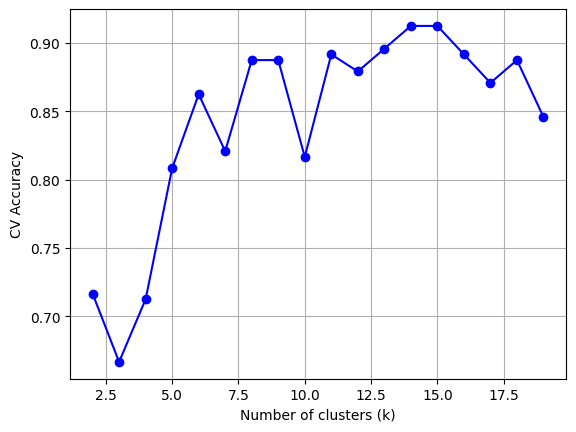


Best k = 14 with accuracy = 0.912


In [137]:
# Plot results
plt.plot(k_range, accuracies, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

best_k = k_range[np.argmax(accuracies)]
print(f'\nBest k = {best_k} with accuracy = {max(accuracies):.3f}')

## DBSCAN

In [147]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
train_clusters_db = dbscan.fit_predict(X_train_split)

In [148]:
# Count DBSCAN clusters
db_counts = pd.Series(train_clusters_db).value_counts().sort_index()
print("DBSCAN clusters:")
for cluster, count in db_counts.items():
    print(f"Cluster {cluster}: {count}")

DBSCAN clusters:
Cluster -1: 2152


In [150]:
# Map DBSCAN clusters to sii
db_cluster_to_sii = pd.Series(y_train_split, index=pd.Series(train_clusters_db)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
db_cluster_to_sii

-1    0.0
dtype: float64

In [151]:
test_clusters_db = dbscan.fit_predict(X_cv)
db_predictions = pd.Series(test_clusters_db).map(db_cluster_to_sii)
print(f"\nDBSCAN Accuracy: {accuracy_score(y_cv, db_predictions):.3f}")


DBSCAN Accuracy: 0.617


### Tuning the Model

In [155]:
# Try different eps values
eps_range = np.arange(0.1, 2, 0.1)
accuracies = []

for eps in eps_range:

    # DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=5)
    train_clusters_db = dbscan.fit_predict(X_train_split)
    
    # Map DBSCAN clusters to sii
    db_cluster_to_sii = pd.Series(y_train_split, index=pd.Series(train_clusters_db)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
    test_clusters_db = dbscan.fit_predict(X_cv)
    db_predictions = pd.Series(test_clusters_db).map(db_cluster_to_sii)

    acc = accuracy_score(y_cv, db_predictions)
    accuracies.append(acc)
    print(f'eps={eps:.1f}, accuracy={acc:.3f}')

eps=0.1, accuracy=0.617
eps=0.2, accuracy=0.617
eps=0.3, accuracy=0.617
eps=0.4, accuracy=0.617
eps=0.5, accuracy=0.617
eps=0.6, accuracy=0.617
eps=0.7, accuracy=0.617
eps=0.8, accuracy=0.617
eps=0.9, accuracy=0.617
eps=1.0, accuracy=0.617
eps=1.1, accuracy=0.617
eps=1.2, accuracy=0.617
eps=1.3, accuracy=0.617
eps=1.4, accuracy=0.617
eps=1.5, accuracy=0.617
eps=1.6, accuracy=0.617
eps=1.7, accuracy=0.617
eps=1.8, accuracy=0.617
eps=1.9, accuracy=0.617


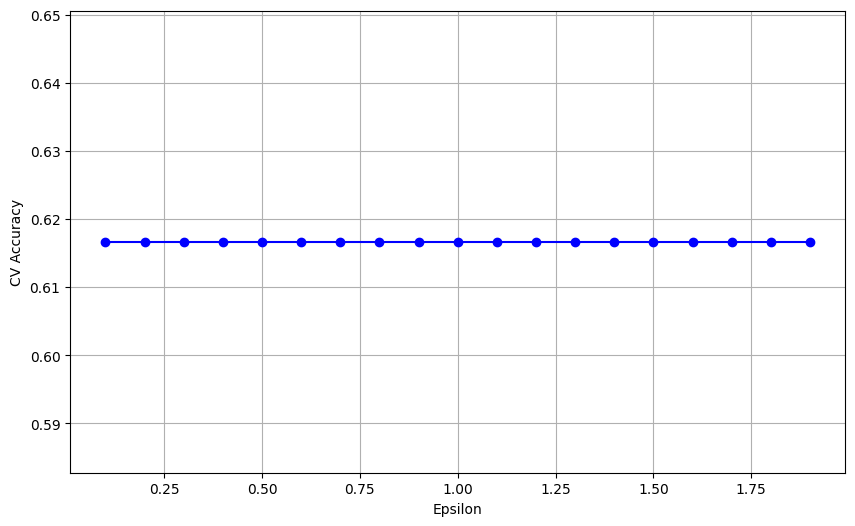


Best eps = 0.1 with accuracy = 0.617


In [156]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(eps_range, accuracies, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

best_eps = eps_range[np.argmax(accuracies)]
print(f'\nBest eps = {best_eps:.1f} with accuracy = {max(accuracies):.3f}')

## Agglomerative Hierarchical Clustering

In [159]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=4)
train_clusters_h = hierarchical.fit_predict(X_train_split)

In [160]:
# Count Hierarchical clusters
h_counts = pd.Series(train_clusters_h).value_counts().sort_index()
print("\nHierarchical clusters:")
for cluster, count in h_counts.items():
    print(f"Cluster {cluster}: {count}")


Hierarchical clusters:
Cluster 0: 454
Cluster 1: 494
Cluster 2: 588
Cluster 3: 616


In [161]:
# Map Hierarchical clusters to sii
h_cluster_to_sii = pd.Series(y_train_split, index=pd.Series(train_clusters_h)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
h_cluster_to_sii

0    2.0
1    0.0
2    0.0
3    0.0
dtype: float64

In [163]:
# Predict on CV set
test_clusters_h = hierarchical.fit_predict(X_cv)
h_predictions = pd.Series(test_clusters_h).map(h_cluster_to_sii)

In [164]:
print(f"\nHierarchical Accuracy: {accuracy_score(y_cv, h_predictions):.3f}")


Hierarchical Accuracy: 0.371


### Tuning the Model

In [166]:
# Hierarchical parameter tuning
n_clusters_range = range(2, 11)
accuracies = []

for n in n_clusters_range:
    hierarchical = AgglomerativeClustering(n_clusters=n)
    
    train_clusters = hierarchical.fit_predict(X_train_split)
    
    cluster_sii = pd.Series(y_train_split, index=pd.Series(train_clusters)).groupby(level=0).agg(lambda x: x.value_counts().index[0])
    
    test_clusters = hierarchical.fit_predict(X_cv)
    predictions = pd.Series(test_clusters).map(cluster_sii)
    
    acc = accuracy_score(y_cv, predictions)
    accuracies.append(acc)
    print(f'n_clusters={n}, accuracy={acc:.3f}')

n_clusters=2, accuracy=0.592
n_clusters=3, accuracy=0.500
n_clusters=4, accuracy=0.371
n_clusters=5, accuracy=0.708
n_clusters=6, accuracy=0.633
n_clusters=7, accuracy=0.558
n_clusters=8, accuracy=0.558
n_clusters=9, accuracy=0.329
n_clusters=10, accuracy=0.267


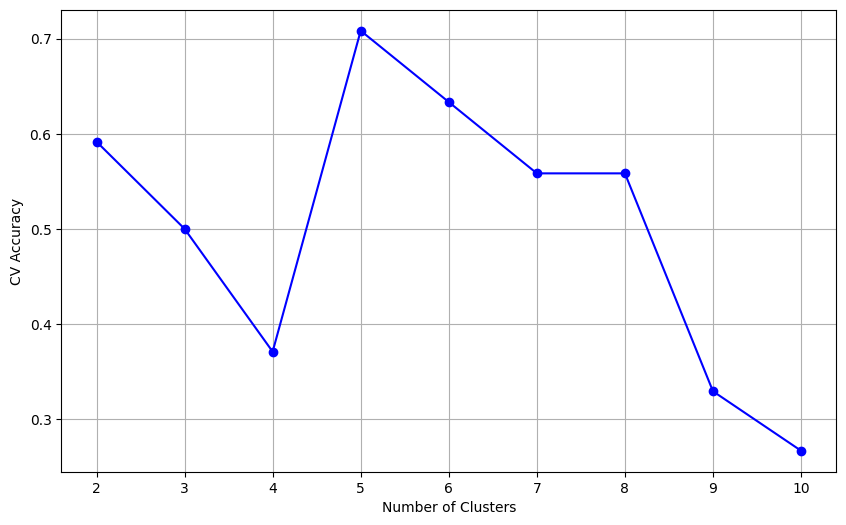

In [167]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, accuracies, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()

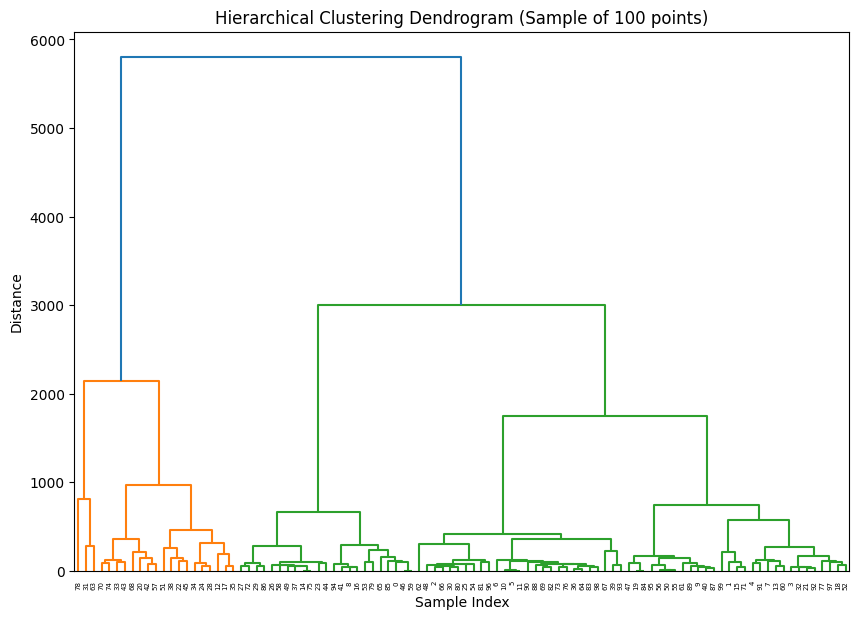

In [168]:
# Plot dendrogram for visualization
plt.figure(figsize=(10, 7))
linkage_matrix = linkage(X_train.sample(n=100), 'ward')
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram (Sample of 100 points)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Semi-Supervised Learning

In [ ]:


# Create a new y with the encoded values, keeping NaN for the unlabeled rows
y_transductive = y.copy()  # Copy the original y
y_transductive[labeled_mask] = y_encoded.flatten()  # Replace only the labeled rows with the encoded values
y_transductive[~labeled_mask] = -1  # Mark the unlabeled rows with -1

# Convert to numpy arrays
X = df_X_train.values
y_array = y_transductive.values

# Split labeled data into train and test
X_labeled = X[labeled_mask]  # Features where y is labeled
y_labeled = y_array[labeled_mask]  # Labels where y is not NaN

# Split the data into training and test sets (using only labeled data)
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled, y_labeled, test_size=test_size, random_state=random_state
)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Label Spreading for semi-supervised learning
label_spreader = LabelSpreading(
    kernel='rbf',
    alpha=0.8,
    max_iter=30,
    n_jobs=-1
)
label_spreader.fit(X_scaled, y_array)  # Train on the entire dataset (labeled + unlabeled)
    
# Get propagated labels
propagated_labels = label_spreader.transduction_

# Prepare data for Random Forest
# Use both original labeled and propagated labels
valid_label_mask = propagated_labels != -1
X_for_rf = X_scaled[valid_label_mask]  # Only use rows with valid labels
y_for_rf = propagated_labels[valid_label_mask]  # Corresponding propagated labels

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=random_state,
    class_weight='balanced'
)
rf_classifier.fit(X_for_rf, y_for_rf)

# Prepare results
results = {
    'propagated_labels': propagated_labels,
    'classifier': rf_classifier,
    'scaler': scaler
}

# If we have a test set, evaluate performance
if len(X_test) > 0:
    X_test_scaled = scaler.transform(X_test)
    y_pred = rf_classifier.predict(X_test_scaled)
    
    results.update({
        'test_predictions': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    })

return results

In [176]:
def semi_supervised_classification(df_X_train, y, test_size=0.2, random_state=42):
    """
    Perform semi-supervised multi-class classification.
    
    Parameters:
    df_X_train (DataFrame): Numerical feature matrix with no missing values
    y (Series/array): Categorical target with missing values
    test_size (float): Proportion of data to use for testing
    random_state (int): Random seed for reproducibility
    
    Returns:
    dict: Classification results
    """
    # Ensure y is a Series
    if isinstance(y, pd.DataFrame):
        y = y.squeeze()

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Label Spreading for semi-supervised learning
    label_spreader = LabelSpreading(
        kernel='rbf',
        alpha=0.8,
        max_iter=30,
        n_jobs=-1
    )
    label_spreader.fit(df_X_train, y)  # Train on the entire dataset (labeled + unlabeled)
    
    # Get propagated labels
    propagated_labels = label_spreader.transduction_
    
    # Prepare data for Random Forest
    # Use both original labeled and propagated labels
    valid_label_mask = propagated_labels != -1
    X_for_rf = df_X_train[valid_label_mask]  # Only use rows with valid labels
    y_for_rf = propagated_labels[valid_label_mask]  # Corresponding propagated labels
    
    # Train Random Forest Classifier
    rf_classifier = RandomForestClassifier(
        n_estimators=100,
        random_state=random_state,
        class_weight='balanced'
    )
    rf_classifier.fit(X_for_rf, y_for_rf)
    
    # Prepare results
    results = {
        'propagated_labels': propagated_labels,
        'classifier': rf_classifier,
        'scaler': scaler
    }
    
    # If we have a test set, evaluate performance
    if len(X_test) > 0:
        X_test_scaled = scaler.transform(X_test)
        y_pred = rf_classifier.predict(X_test_scaled)
        
        results.update({
            'test_predictions': y_pred,
            'accuracy': accuracy_score(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred)
        })
    
    return results

# Usage example (replace with your actual data)
results = semi_supervised_classification(X_train_split, y_train_split)
print(results['classification_report'])

ValueError: could not convert string to float: '00008ff9'